### 1.0 Introduction

This notebook is the final project for [Python for Data Journalists: Analyzing Money in Politics](http://journalismcourses.org/course/view.php?id=52), a course offered by the [Kinght Center for Journalism in the Americas](https://knightcenter.utexas.edu/). The project summarizes and plots the funding received by the various ballot measures from the November 8, 2016 election in California, as well as the voting results. 

### 2.0 Reading the data

First we import the libraries we will be using and then read the two datasets into pandas dataframes. The first dataset has the various committees that raised funds in favor of or to support the propositions. The second dataset contains the individual contributions to each committee. The two datsets share the "calaccess_committee_id" field, which we will use to merge the two.

In [1]:
# Importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Reading the propositions dataset
props = pd.read_csv("http://www.firstpythonnotebook.org/_static/committees.csv")
props[["prop_name", "calaccess_committee_id", "committee_name", "committee_position"]].head(3)

,prop_name,calaccess_committee_id,committee_name,committee_position
0,PROPOSITION 051 - SCHOOL BONDS. FUNDING FOR K-...,1374469,YES ON PROPOSITION 51 - CALIFORNIANS FOR QUALI...,SUPPORT
1,PROPOSITION 051 - SCHOOL BONDS. FUNDING FOR K-...,1220380,COMMUNITY COLLEGE FACILITY COALITION ISSUES CO...,SUPPORT
2,PROPOSITION 051 - SCHOOL BONDS. FUNDING FOR K-...,1282321,TORLAKSON'S INVEST IN CALIFORNIA A BALLOT MEAS...,SUPPORT


In [3]:
# Reading the contributions dataset
contribs = pd.read_csv("http://www.firstpythonnotebook.org/_static/contributions.csv")
contribs[["calaccess_committee_id", "committee_name", "contributor_lastname", \
          "contributor_firstname", "contributor_state", "contributor_zip", "amount"]].head(3)

,calaccess_committee_id,committee_name,contributor_lastname,contributor_firstname,contributor_state,contributor_zip,amount
0,1386560,ADULT USE CAMPAIGN FOR PROPOSITION 64; THE,BERGMAN,GRETCHEN,CA,91978,84.0
1,1386560,ADULT USE CAMPAIGN FOR PROPOSITION 64; THE,KAHLE,MYRNA,CA,92109,35.0
2,1386560,ADULT USE CAMPAIGN FOR PROPOSITION 64; THE,MCDEVITT,LEO,CA,92025,198.0


### 3.0 Building the dataframe

We will create a dataframe that includes the proposition and the amount of funding and percentage of votes received by each side. We start by extracting the propositions' names from the **`props`** dataframe, which has the *full* name of each. We just want "Proposition 0xx"

In [4]:
def substr(my_prop):
    '''Returns the name of the proposition, strips description off.'''
    return my_prop[0:15]

# Get the *full* name of each prop
all_props = props.prop_name.unique()
all_props = np.sort(all_props)

# Strip off description using substr()
substr_vec = np.vectorize(substr) # vectorize function to avoid loops
props_names = substr_vec(all_props) # apply vectorized function to obtain propositions' names
props_names

array(['PROPOSITION 051', 'PROPOSITION 052', 'PROPOSITION 053',
       'PROPOSITION 054', 'PROPOSITION 055', 'PROPOSITION 056',
       'PROPOSITION 057', 'PROPOSITION 058', 'PROPOSITION 059',
       'PROPOSITION 060', 'PROPOSITION 061', 'PROPOSITION 062',
       'PROPOSITION 063', 'PROPOSITION 064', 'PROPOSITION 065',
       'PROPOSITION 066', 'PROPOSITION 067'],
      dtype='|S15')

Next we compute the total amount spent on each ballot measure. We do it for each measure by sub-setting the **`props`** dataframe to include entries that match the specific measure, merging on "calaccess_committee_id", splitting the merged dataframe into **`support`** and **`oppose`** dataframes, and then summing up the contributions for each.

In [5]:
support_totals = []
oppose_totals = []

for prop in all_props:
    prop_subset = props[props.prop_name == prop] # filter props for each ballot measure
    merged = pd.merge(prop_subset, contribs, on = "calaccess_committee_id") # merge
    # Splitting the merged df into support and oppose df's, and computing total $ for each
    support = merged[merged.committee_position == "SUPPORT"]
    support_totals.append(support.amount.sum())
    oppose = merged[merged.committee_position == "OPPOSE"]
    oppose_totals.append(oppose.amount.sum())

# Total $ spent on each proposition
total_spent = [support_totals[idx] + oppose_totals[idx] for idx in range(17)]

Now we add the election results for each proposition, which can be obtained from [Ballotpedia](https://ballotpedia.org/California_2016_ballot_propositions).

In [6]:
results_col = [list(2*"Y"), list('N'), list(6*"Y"), list(3*"N"), list(2*"Y"), list('N'), list(2*"Y")]
# https://stackoverflow.com/questions/952914/making-a-flat-list-out-of-list-of-lists-in-python
results_col = sum(results_col, [])

Let's build a dataframe with what we have. We will work on the formatting of the various columns in a bit.

In [7]:
my_dict = {"Prop": props_names, "Support": support_totals, "Oppose": oppose_totals, "Total": total_spent, "Winner": results_col}
df = pd.DataFrame(my_dict, columns = ["Prop", "Support", "Oppose", "Total", "Winner"])
df.head(3)

,Prop,Support,Oppose,Total,Winner
0,PROPOSITION 051,12987942.84,0.00,12987942.84,Y
1,PROPOSITION 052,12756517.34,3526622.28,16283139.62,Y
2,PROPOSITION 053,3500000.00,18840500.00,22340500.00,N


We can compute the difference in funding levels between the "Yes" and "No" for each proposition. We are also interested to find out if there were cases in which the side with the most funding *lost*.

In [8]:
# Computing the dollar margins of victories
# Where the better funded alternative lost, we will use a negative sign
winner_list = list(df["Winner"].values)
support_list = list(df["Support"].values)
oppose_list = list(df["Oppose"].values)
diff_list = [support_list[i] - oppose_list[i] for i in range(17)]
margin_list = [0 for i in range(17)]
for i in range(17):
    if ((support_list[i] - oppose_list[i]) > 0 and winner_list[i] == "Y"):
        margin_list[i] = support_list[i] - oppose_list[i]
    elif ((support_list[i] - oppose_list[i]) < 0 and winner_list[i] == "N"):
        margin_list[i] = oppose_list[i] - support_list[i]
    elif ((support_list[i] - oppose_list[i]) > 0 and winner_list[i] == "N"):
        margin_list[i] = oppose_list[i] - support_list[i]
    elif ((support_list[i] - oppose_list[i]) < 0 and winner_list[i] == "Y"):
        margin_list[i] = support_list[i] - oppose_list[i]

df["$ Margin"] = margin_list
df.head(6)

,Prop,Support,Oppose,Total,Winner,$ Margin
0,PROPOSITION 051,12987942.84,0.00,12987942.84,Y,12987942.84
1,PROPOSITION 052,12756517.34,3526622.28,16283139.62,Y,9229895.06
2,PROPOSITION 053,3500000.00,18840500.00,22340500.00,N,15340500.00
3,PROPOSITION 054,152178.96,0.00,152178.96,Y,152178.96
4,PROPOSITION 055,56658726.67,0.00,56658726.67,Y,56658726.67
5,PROPOSITION 056,33683287.67,54686004.00,88369291.67,Y,-21002716.33


Indeed, we see that [Proposition 56's](https://ballotpedia.org/California_Proposition_56,_Tobacco_Tax_Increase_(2016%29) "No" outspent the "Yes" by more than $\$20M$ and not only lost, but did so in a landslide. The measure proposed a $\$2$ tax increase on each cigarette pack.

Next we enter the voting percentages for each measure, once again from Ballotpedia, and compute the percentage margin of victory, similarly to the way we computed the dollar margins.

In [9]:
percentage_yes = [55.18, 70.07, 49.42, 65.37, 63.27, 64.43, 64.46, 73.52, 53.18, \
                  46.33, 46.80, 53.15, 63.08, 57.13, 46.10, 51.13, 53.27]
percentage_no = [44.82, 29.93, 50.58, 34.63, 36.73, 35.57, 35.54, 26.48, 46.82, \
                 53.67, 53.20, 46.85, 36.92, 42.87, 53.90, 48.87, 46.73]
df["% Yes"] = pd.Series(percentage_yes)
df["% No"] = pd.Series(percentage_no)
df.head(3)

,Prop,Support,Oppose,Total,Winner,$ Margin,% Yes,% No
0,PROPOSITION 051,12987942.84,0.00,12987942.84,Y,12987942.84,55.18,44.82
1,PROPOSITION 052,12756517.34,3526622.28,16283139.62,Y,9229895.06,70.07,29.93
2,PROPOSITION 053,3500000.00,18840500.00,22340500.00,N,15340500.00,49.42,50.58


In [10]:
# Computing the percentage margins of victories
# Where the better funded alternative lost, we will use a negative sign
margin_percent_list = [0 for i in range(17)]
for i in range(17):
    if ((percentage_yes[i] - percentage_no[i]) > 0 and (support_list[i] - oppose_list[i]) > 0):
        margin_percent_list[i] = percentage_yes[i] - percentage_no[i]
    elif ((percentage_yes[i] - percentage_no[i]) < 0 and (support_list[i] - oppose_list[i]) < 0):
        margin_percent_list[i] = percentage_no[i] - percentage_yes[i]
    elif ((percentage_yes[i] - percentage_no[i]) > 0 and (support_list[i] - oppose_list[i]) < 0):
        margin_percent_list[i] = percentage_no[i] - percentage_yes[i]
    elif ((percentage_yes[i] - percentage_no[i]) < 0 and (support_list[i] - oppose_list[i]) > 0):
        margin_percent_list[i] = percentage_yes[i] - percentage_no[i]

df["% Margin"] = margin_percent_list
df.head(6)

,Prop,Support,Oppose,Total,Winner,$ Margin,% Yes,% No,% Margin
0,PROPOSITION 051,12987942.84,0.00,12987942.84,Y,12987942.84,55.18,44.82,10.36
1,PROPOSITION 052,12756517.34,3526622.28,16283139.62,Y,9229895.06,70.07,29.93,40.14
2,PROPOSITION 053,3500000.00,18840500.00,22340500.00,N,15340500.00,49.42,50.58,1.16
3,PROPOSITION 054,152178.96,0.00,152178.96,Y,152178.96,65.37,34.63,30.74
4,PROPOSITION 055,56658726.67,0.00,56658726.67,Y,56658726.67,63.27,36.73,26.54
5,PROPOSITION 056,33683287.67,54686004.00,88369291.67,Y,-21002716.33,64.43,35.57,-28.86


Now that we have the dataframe the way we want it, we can format it to make it more readable by using pandas' [**`IndexSlice`**](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.IndexSlice.html) in combination with the [**`format()`**](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.io.formats.style.Styler.format.html) and [**`applymap()`**](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.applymap.html) dataframe methods. This [styling guide](https://pandas.pydata.org/pandas-docs/stable/style.html) provides very useful examples of selective formatting.

In [11]:
def color_negative_red(val):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for negative
    strings, black otherwise.
    """
    color = 'red' if val < 0 else 'black'
    return 'color: %s' % color

# https://stackoverflow.com/questions/4768941/how-to-break-a-line-of-chained-methods-in-python
df.sort_values("Total", ascending = False).style \
  .format("{0:,.2f}", subset=pd.IndexSlice[:, ['% No', '% Yes', '% Margin']]) \
  .format("${0:,.2f}", subset=pd.IndexSlice[:, ['Support', 'Oppose', 'Total', '$ Margin']])\
  .applymap(color_negative_red, subset = pd.IndexSlice[:, ['$ Margin', '% Margin']])

,Prop,Support,Oppose,Total,Winner,$ Margin,% Yes,% No,% Margin
10,PROPOSITION 061,"$18,897,335.25","$108,417,232.00","$127,314,567.25",N,"$89,519,896.75",46.80,53.20,6.40
5,PROPOSITION 056,"$33,683,287.67","$54,686,004.00","$88,369,291.67",Y,"$-21,002,716.33",64.43,35.57,-28.86
4,PROPOSITION 055,"$56,658,726.67",$0.00,"$56,658,726.67",Y,"$56,658,726.67",63.27,36.73,26.54
13,PROPOSITION 064,"$32,675,806.00","$2,501,211.64","$35,177,017.64",Y,"$30,174,594.36",57.13,42.87,14.26
15,PROPOSITION 066,"$16,836,069.81","$17,455,169.49","$34,291,239.30",Y,"$-619,099.68",51.13,48.87,-2.26
11,PROPOSITION 062,"$16,000,608.37","$16,836,069.81","$32,836,678.18",N,"$835,461.44",53.15,46.85,-6.30
2,PROPOSITION 053,"$3,500,000.00","$18,840,500.00","$22,340,500.00",N,"$15,340,500.00",49.42,50.58,1.16
6,PROPOSITION 057,"$19,307,322.73","$790,047.00","$20,097,369.73",Y,"$18,517,275.73",64.46,35.54,28.92
1,PROPOSITION 052,"$12,756,517.34","$3,526,622.28","$16,283,139.62",Y,"$9,229,895.06",70.07,29.93,40.14
0,PROPOSITION 051,"$12,987,942.84",$0.00,"$12,987,942.84",Y,"$12,987,942.84",55.18,44.82,10.36


### 4.0 Summary plots

Here we plot the totals spent on each proposition and the voting results.

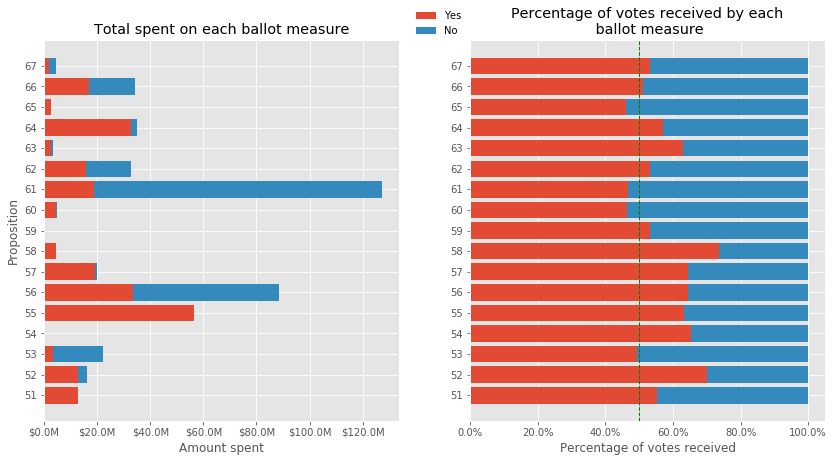

In [21]:
from matplotlib.ticker import FuncFormatter

def currency(x, pos):
    'The two args are the value and tick position'
    return '${:1.1f}M'.format(x*1e-6)

def percent(x, pos):
    'The two args are the value and tick position'
    return '{:,.1f}%'.format(x)

x = df.Prop.values
prop_numbers = [prop_name[-2:] for prop_name in df["Prop"].values]

fig, (ax0, ax1) = plt.subplots(nrows=1,ncols=2, sharey=False, figsize=(14, 7))
plt.style.use('ggplot')
ind = np.arange(17)

bar00 = ax0.barh(bottom = ind, width = df["Support"].values)
bar01 = ax0.barh(bottom = ind, width = df["Oppose"].values, left = df["Support"].values)
ax0.set_yticks(ind)
ax0.set_yticklabels(prop_numbers)

ax0.set(title='Total spent on each ballot measure', xlabel='Amount spent', ylabel='Proposition')
ax0.legend((bar00[0], bar01[0]), ('Yes', 'No'), bbox_to_anchor=(1.2, 1.1), facecolor = "white", frameon = False)

bar10 = ax1.barh(bottom = ind, width = df["% Yes"].values)
bar11 = ax1.barh(bottom = ind, width = df["% No"].values, left = df["% Yes"].values)

ax1.set_yticks(ind)
ax1.set_yticklabels(prop_numbers)

ax1.set(title='Percentage of votes received by each\n ballot measure', xlabel='Percentage of votes received', ylabel='')

ax1.axvline(x=50.0, linestyle='--', color = "green", linewidth = 1)

formatter0 = FuncFormatter(currency)
ax0.xaxis.set_major_formatter(formatter0)

formatter1 = FuncFormatter(percent)
ax1.xaxis.set_major_formatter(formatter1)

plt.show()

### 5.0 Most expensive ballot measures

The two most most expensive ballot measures in California's November 2016 election were [Proposition 61](https://ballotpedia.org/California_Proposition_61,_Drug_Price_Standards_(2016%29) and [Proposition 56](https://ballotpedia.org/California_Proposition_56,_Tobacco_Tax_Increase_(2016%29).

#### 5.1 Proposition 61

[Proposition 61](https://ballotpedia.org/California_Proposition_61,_Drug_Price_Standards_(2016%29) was the most expensive ballot measure in the whole country. It would have required state government agencies to pay no more for prescription drugs than the VA does. The proposition was defeated. The "No" campaign received almost six times as much funding ($\$108M$) as the "Yes" did ($\$19M$). As we will see shortly, big pharmaceutical companies were the main contributors to the "No" campaign.

First, let's filter the **`props`** dataframe to include only data relevant to 61. Then we will merge that subset with the **`contribs`** dataframe, and then we will split the merged dataframe into "support" and "oppose" dataframes.

In [13]:
prop_subset = props[props.prop_name == "PROPOSITION 061- STATE PRESCRIPTION DRUG PURCHASES. PRICING STANDARDS. INITIATIVE STATUTE."]
merged = pd.merge(prop_subset, contribs, on = "calaccess_committee_id")
support = merged[merged.committee_position == "SUPPORT"]
oppose = merged[merged.committee_position == "OPPOSE"]

Take a look at the top 10 supporters of 61, using pandas' **`groupby()`** and **`sum()`** methods:

In [14]:
support_top10 = support.groupby("contributor_lastname").amount.sum().reset_index() \
                       .sort_values("amount", ascending=False).head(10)
support_top10.style.format("${0:,.2f}", subset=pd.IndexSlice[:, ['amount']])

,contributor_lastname,amount
5,AIDS HEALTHCARE FOUNDATION,"$18,675,000.00"
55,CALIFORNIANS FOR LOWER DRUG PRICES,"$150,000.00"
54,CALIFORNIA NURSES ASSOCIATION PAC (CNA-PAC),"$50,000.00"
253,"NORTHERN CALIFORNIA DISTRICT COUNCIL, ILWU","$1,000.00"
35,BLUMENSTEIN,$600.00
74,CURTIS,$600.00
380,YORKIN,$600.00
212,MARTIN,$510.00
197,LINCOLN,$500.00
62,CHAPPELLE,$500.00


We can see that the AIDS Healthcare Foundation was by far the most significant contributor to the "Yes" campaign. Let's take a look at the "No".

In [15]:
oppose_top10 = oppose.groupby("contributor_lastname").amount.sum().reset_index() \
                     .sort_values("amount", ascending=False).head(10)
oppose_top10.style.format("${0:,.2f}", subset=pd.IndexSlice[:, ['amount']])

,contributor_lastname,amount
27,"PFIZER, INC.","$9,420,395.00"
22,"MERCK & CO., INC.","$9,420,395.00"
19,JOHNSON & JOHNSON,"$9,301,646.00"
3,AMGEN INC.,"$7,635,768.00"
0,ABBVIE INC.,"$6,859,873.00"
29,SANOFI-AVENTIS U.S. LLC,"$6,720,945.00"
5,ASTRAZENECA PHARMACEUTICALS LP,"$6,080,535.00"
2,"ALLERGAN USA, INC.","$5,079,332.00"
23,NOVARTIS PHARMACEUTICALS CORPORATION,"$4,728,302.00"
17,GLAXOSMITHKLINE,"$4,528,527.00"


The opponents' top-10 is comprised of big pharmaceutical companies, each of which contributed millions to the "No" campaign.

Let's plot these results.

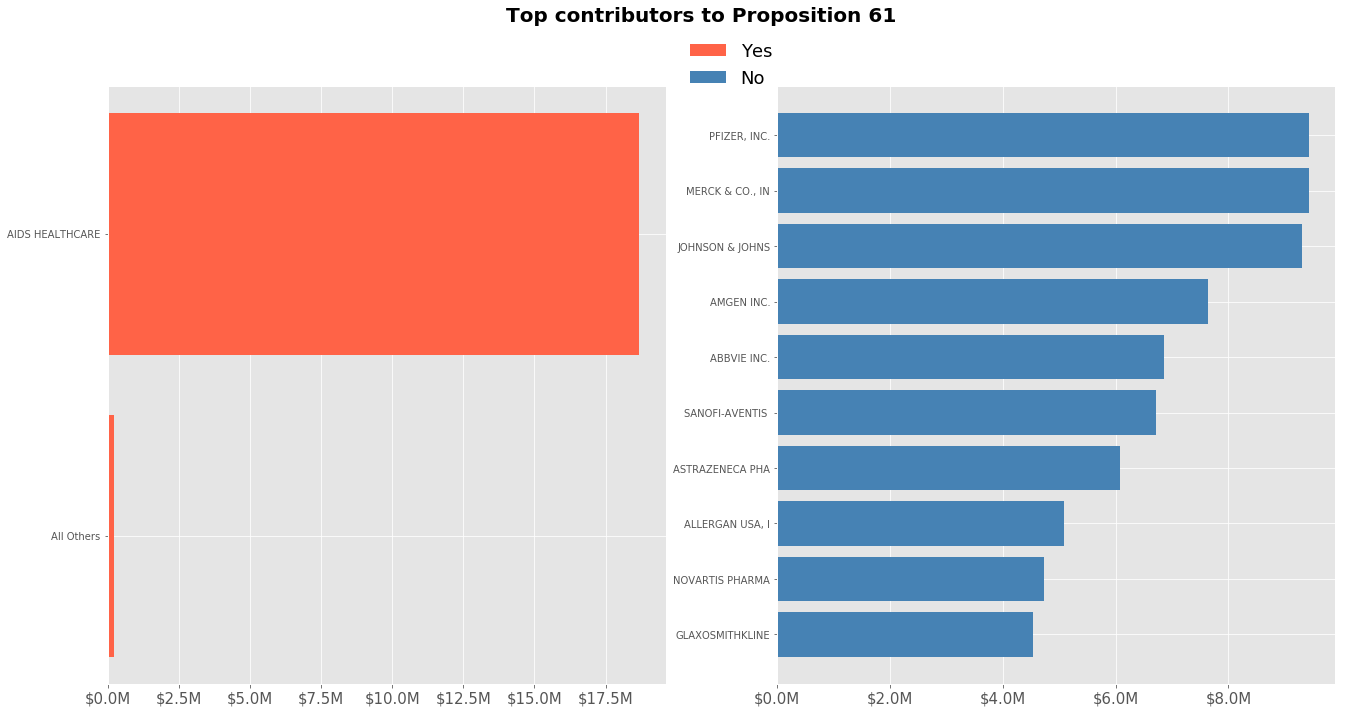

In [16]:
# Since the AIDS Healthcare Foundation's contribution dwarfs all others',
# we will plot just 2 bars: the AHF and "all others"
support_total = support["amount"].sum() # total amount "Yes" received
support_top_donor = support_top10["amount"].values[0] # AHF's contribution
support_all_other = support_total - support_top_donor # combined contributions from all other supporters

def substr(my_donor):
    '''Returns the first 15 characters of the donor'''
    return my_donor[0:15]

substr_vec = np.vectorize(substr) # vectorize function to avoid loops

# Top No donors
top10_opponents = oppose_top10["contributor_lastname"].values[::-1] # reverse array so largest is plotted at the top
top10_opponents_names = substr_vec(top10_opponents) # keep only first 15 characters
top10_opponents_amounts = oppose_top10["amount"].values[::-1] # reverse array so largest is plotted at the top

fig, (ax0, ax1) = plt.subplots(nrows=1,ncols=2, sharey=False, figsize=(22, 11))
plt.style.use('ggplot')
ind = np.arange(10)

bar00 = ax0.barh(bottom = ind[0:2], width = [support_all_other, support_top_donor], color = "tomato")

ax0.set_yticks(ind[0:2])
ax0.set_yticklabels(["All Others", support_top10["contributor_lastname"].values[0][0:15]])

# https://stackoverflow.com/questions/3899980/how-to-change-the-font-size-on-a-matplotlib-plot
# binaryfunt's answer
ax0.get_xticklabels = [label.set_fontsize(15) for label in ax0.get_xticklabels()]

bar01 = ax1.barh(bottom = ind, width = top10_opponents_amounts, color = "steelblue")

ax1.set_yticks(ind)
ax1.set_yticklabels(top10_opponents_names)

ax1.get_xticklabels = [label.set_fontsize(15) for label in ax1.get_xticklabels()]

ax0.xaxis.set_major_formatter(formatter0)
ax1.xaxis.set_major_formatter(formatter0)

ax0.legend((bar00[0], bar01[0]), ('Yes', 'No'), bbox_to_anchor=(1.22, 1.1), facecolor = "white", frameon = False, fontsize = 18)
fig.suptitle('Top contributors to Proposition 61', fontsize=20, fontweight='bold');

plt.show()

#### 5.2 Proposition 56

[Proposition 56](https://ballotpedia.org/California_Proposition_56,_Tobacco_Tax_Increase_(2016%29) was an initiative to increase the tax on cigarette packs by $\$2$. The measure was approved in a landslide, with a margin of almost $30$ percent. This was so even though funding for the "No" campaign exceeded that of the "Yes" by more than $\$20M$.

Let's again filter, merge, and split into "support" and "oppose" dataframes

In [17]:
prop_subset = props[props.prop_name == "PROPOSITION 056 - CIGARETTE TAX TO FUND HEALTHCARE, \
TOBACCO USE PREVENTION, RESEARCH, AND LAW ENFORCEMENT. INITIATIVE CONSTITUTIONAL AMENDMENT AND STATUTE."]
merged = pd.merge(prop_subset, contribs, on = "calaccess_committee_id")
support = merged[merged.committee_position == "SUPPORT"]
oppose = merged[merged.committee_position == "OPPOSE"]

Top supporters:

In [18]:
support_top10 = support.groupby("contributor_lastname").amount.sum().reset_index() \
                       .sort_values("amount", ascending=False).head(10)
support_top10.style.format("${0:,.2f}", subset=pd.IndexSlice[:, ['amount']])

,contributor_lastname,amount
83,STEYER,"$13,050,000.00"
11,"CA HOSPITALS COMMITTEE ON ISSUES, (CHCI) SPONSORED BY CA ASSOCIATION OF HOSPITALS & HEALTH SYSTEMS (CAHHS)","$9,000,000.00"
18,CALIFORNIA STATE COUNCIL OF SERVICE EMPLOYEES ISSUES COMMITTEE,"$2,000,000.00"
16,CALIFORNIA MEDICAL ASSOCIATION,"$1,000,000.00"
15,"CALIFORNIA HOSPITALS COMMITTEE ON ISSUES, (CHCI) SPONSORED BY CALIFORNIA ASSOCIATION OF HOSPITALS AND HEALTH SYSTEMS (CAHHS)","$1,000,000.00"
14,CALIFORNIA DENTAL ASSOCIATION,"$1,000,000.00"
43,"KAISER FOUNDATION HEALTH PLAN, INC. AND THE HOSPITALS","$1,000,000.00"
0,"AMERICAN CANCER SOCIETY, INC.","$800,000.00"
8,BLOOMBERG,"$500,000.00"
1,"AMERICAN FEDERATION OF STATE, COUNTY AND MUNICIPAL EMPLOYEES, AFL-CIO (MPO)","$450,000.00"


The top contributor to the "Yes" was actually an individual, philantropist [Tom Steyer](https://en.wikipedia.org/wiki/Tom_Steyer). The top opponents of the measure were:

In [19]:
oppose_top10 = oppose.groupby("contributor_lastname").amount.sum().reset_index() \
                     .sort_values("amount", ascending=False).head(10)
oppose_top10.style.format("${0:,.2f}", subset=pd.IndexSlice[:, ['amount']])

,contributor_lastname,amount
21,"PHILIP MORRIS USA INC. (MADE BY ITS SERVICE COMPANY, ALTRIA CLIENT SERVICES LLC)","$28,450,188.00"
25,"R.J. REYNOLDS TOBACCO COMPANY (MADE BY ITS SERVICE COMPANY, RAI SERVICES COMPANY)","$20,140,000.00"
31,"UST LLC (MADE BY ITS SERVICE COMPANY, ALTRIA CLIENT SERVICES LLC), AN AFFILIATE OF PHILIP MORRIS USA INC.","$3,299,144.00"
9,ITG BRANDS LLC,"$1,050,000.00"
11,"JOHN MIDDLETON CO. (MADE BY ITS SERVICE COMPANY, ALTRIA CLIENT SERVICES LLC), AN AFFILIATE OF PHILIP MORRIS USA INC.","$1,018,660.00"
5,"FONTEM VENTURES USA, INC.","$450,000.00"
14,"MCLANE COMPANY, INC.","$100,000.00"
19,"NUMARK LLC (MADE BY ITS SERVICE COMPANY, ALTRIA CLIENT SERVICES LLC), AN AFFILIATE OF PHILIP MORRIS USA INC.","$92,008.00"
3,"CORE-MARK INTERNATIONAL, INC.","$50,000.00"
7,INTERNATIONAL PREMIUM CIGAR & PIPE RETAILERS ASSOCIATION,"$10,000.00"


As could have probably been expected, the large tobacco companies went to great lengths to defeat the measure, unsuccesfully.

Now let's plot

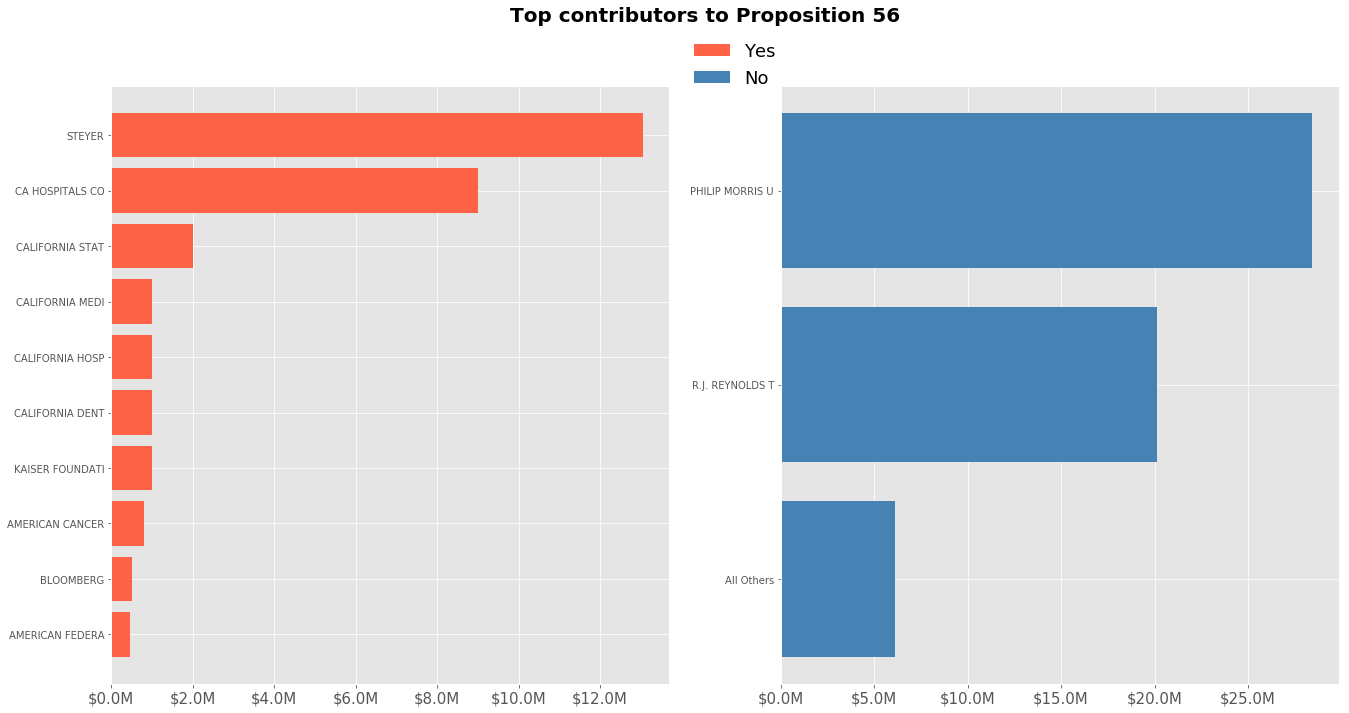

In [20]:
# Similarly as we did earlier, we will plot the top 2 donors, Philip Morris and RJ Reynolds,
# and lump all others together
oppose_total = oppose["amount"].sum()
oppose_top_donor = oppose_top10["amount"].values[0]
oppose_top_donor_2 = oppose_top10["amount"].values[1]
oppose_all_other = oppose_total - oppose_top_donor - oppose_top_donor_2

# Top Yes donors
top10_supporters = support_top10["contributor_lastname"].values[::-1] # reverse array so largest is plotted at the top
top10_supporters_names = substr_vec(top10_supporters) # keep only first 15 characters of donor
top10_supporters_amounts = support_top10["amount"].values[::-1] # reverse array so largest is plotted at the top

fig, (ax0, ax1) = plt.subplots(nrows=1,ncols=2, sharey=False, figsize=(22, 11))
plt.style.use('ggplot')
ind = np.arange(10)

bar00 = ax0.barh(bottom = ind, width = top10_supporters_amounts, color = "tomato")

ax0.set_yticks(ind)
ax0.set_yticklabels(top10_supporters_names)

# https://stackoverflow.com/questions/3899980/how-to-change-the-font-size-on-a-matplotlib-plot
# binaryfunt's answer
ax0.get_xticklabels = [label.set_fontsize(15) for label in ax0.get_xticklabels()]

bar01 = ax1.barh(bottom = ind[0:3], width = [oppose_all_other, oppose_top_donor_2, oppose_top_donor], color = "steelblue")

ax1.set_yticks(ind[0:3])
ax1.set_yticklabels(["All Others", oppose_top10["contributor_lastname"].values[1][0:15], oppose_top10["contributor_lastname"].values[0][0:15]])

ax1.get_xticklabels = [label.set_fontsize(15) for label in ax1.get_xticklabels()]

ax0.xaxis.set_major_formatter(formatter0)
ax1.xaxis.set_major_formatter(formatter0)

ax0.legend((bar00[0], bar01[0]), ('Yes', 'No'), bbox_to_anchor=(1.22, 1.1), facecolor = "white", frameon = False, fontsize = 18)
fig.suptitle('Top contributors to Proposition 56', fontsize=20, fontweight='bold');

plt.show()

### 6.0 References

1. Welsh, B. [***Python for Data Journalists: Analyzing Money in Politics***](http://journalismcourses.org/course/view.php?id=52), June 2017.
2. Emma and Tryptich. [***Making a flat list out of list of lists in Python***](https://stackoverflow.com/questions/952914/making-a-flat-list-out-of-list-of-lists-in-python).
3. Gonera, J. and Hettinger, R. [***How to break a line of chained methods in Python?***](https://stackoverflow.com/questions/4768941/how-to-break-a-line-of-chained-methods-in-python)
4. tomasz74 and Alexander. [***Adding new column to existing DataFrame in Python pandas***](https://stackoverflow.com/questions/12555323/adding-new-column-to-existing-dataframe-in-python-pandas).
5. Moffitt, C. [***Effectively Using Matplotlib***](http://pbpython.com/effective-matplotlib.html).
6. The Matplotlib development team, [***pylab_examples example code: bar_stacked.py***](https://matplotlib.org/examples/pylab_examples/bar_stacked.html).
7. The Matplotlib development team, [***api example code: barchart_demo.py***](https://matplotlib.org/examples/api/barchart_demo.html).
8. PyData Development Team [***pandas.IndexSlice***](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.IndexSlice.html).
9. Schaaf, H. and binaryfunt. [***How to change the font size on a matplotlib plot***](https://stackoverflow.com/questions/3899980/how-to-change-the-font-size-on-a-matplotlib-plot)